In [1]:
import pandas as pd
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize
import seaborn as sns

from matplotlib import rc, rcParams
rcParams['figure.dpi'] = 300

rc('font',**{'family':'sans-serif','serif':['Arial'], 'size':14})
rc('text', usetex=True)

In [2]:
def sigmoid(c, Kd, A, B):
    return  np.log10(A *(10**c/(10**c+10**Kd)) + B)

def rms(y, yfit):
    return np.sqrt(np.sum((y-yfit)**2))

def measure_Kds(mean_log_fluor, std_log_fluor, concs):
    popt, pcov = scipy.optimize.curve_fit(sigmoid,
                                          concs,
                                          mean_log_fluor,
                                          p0=[-9,10**4,10**1],
                                          sigma=std_log_fluor,
                                          absolute_sigma=True,
                                          bounds = [(-16,1,1),(-5,10**6,10**6)],
                                          maxfev=400000)

    return popt, pcov
    
def plot_fit(mean_log_fluor, std_log_fluor, concs, popt, pcov, ax, color_fit='grey', show_kd=True):
    concs_plot = np.linspace(concs.min(), concs.max())
    ax.errorbar(concs, mean_log_fluor, yerr=std_log_fluor, fmt='o', capsize=3)
    ax.plot(concs_plot, sigmoid(concs_plot, *popt), color=color_fit)
    if show_kd:
        ax.axvline(popt[0], linestyle='-', color='red',
                   label=r'$\log_{10} K_D = %.2f \pm %.2f$' % (popt[0], pcov[0][0]))
        ax.axvline(popt[0] + pcov[0][0], linestyle=':', color='red')
        ax.axvline(popt[0] - pcov[0][0], linestyle=':', color='red')
    ax.set_xlim(concs.min(), concs.max())
    ax.set_xlabel('log Antibody')
    ax.set_ylabel('log PE fluorescence')
    ax.legend()
    
# Similar to plot-fit but everything is exponentiated
def plot_fit_exp(mean_log_fluor, std_log_fluor, concs, popt, pcov, ax):
    concs_plot = np.linspace(concs.min(), concs.max())
    ax.errorbar(concs, 10**mean_log_fluor, 
                yerr=np.stack((10**(mean_log_fluor - std_log_fluor), 10**(mean_log_fluor + std_log_fluor))),
                fmt='o', capsize=3)
    ax.plot(concs_plot, 10**sigmoid(concs_plot, *popt), color='grey')
    ax.axvline(popt[0], linestyle='-', color='red',
               label=r'$\log_{10} K_D = %.2f \pm %.2f$' % (popt[0], pcov[0][0]))
    ax.axvline(popt[0] + pcov[0][0], linestyle=':', color='red')
    ax.axvline(popt[0] - pcov[0][0], linestyle=':', color='red')
    ax.set_xlabel('log [ACE]')
    ax.set_ylabel('lPE fluorescence')
    ax.legend()

In [3]:
directory = "../../Additional_data/Isogenic_measurement/20220704_antibodies"
sample_list = pd.read_csv(f"{directory}/samples_list.csv")


def read_file(r):
    try:
        return glob(
    f"../../Additional_data/Isogenic_measurement/20220704_antibodies/export_Specimen_???_{r['Well']}_*_Expressed.csv")[0]
    except:
        print(r)
sample_list["filename"] = sample_list.apply(lambda r: read_file(r),
                                                  axis=1)


def read_PEs(csv_file):
    df = pd.read_csv(csv_file)
    try:
        return df["Comp-PE-A"].to_list()
    except:
        return df["PE-A"].to_list()
        

def read_FITCs(csv_file):
    df = pd.read_csv(csv_file)
    try:
        return df["Comp-FITC-A"].to_list()
    except:
        return df["FITC-A"].to_list()

sample_list["PEs"] = sample_list.filename.apply(read_PEs)
sample_list["FITCs"] = sample_list.filename.apply(read_FITCs)
minFITCs = sample_list.FITCs.apply(np.min).min()
minPEs = sample_list.PEs.apply(np.min).min()
sample_list["logFITCs"] = sample_list.FITCs.apply(lambda x: [np.log10(u - minFITCs + 1) for u in x])
sample_list["logPEs"] = sample_list.PEs.apply(lambda x: [np.log10(u - minPEs + 1) for u in x])
sample_list["mean_log_PE"] = sample_list.logPEs.apply(np.mean)
sample_list["std_log_PE"] = sample_list.logPEs.apply(np.std)# / np.sqrt(df.PEs.apply(len))
spl = sample_list[sample_list["type"] == "kd"].copy()
spl["log_concentration"] = spl.log_concentration.apply(lambda x: -14.0 if float(x)==0 else float(x))
spl["Strain"] = spl.Strain.apply(str)


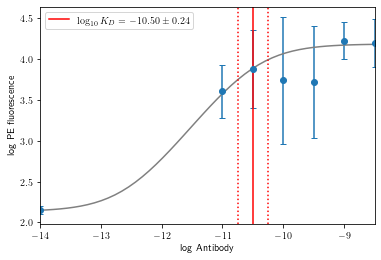

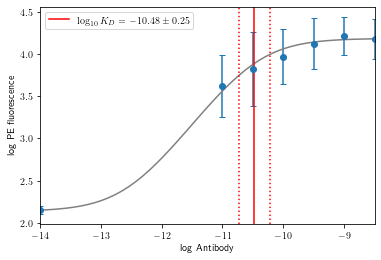

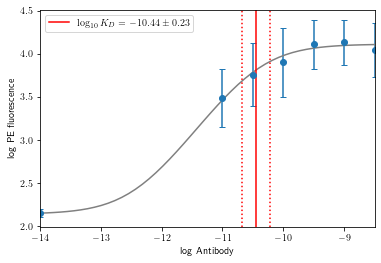

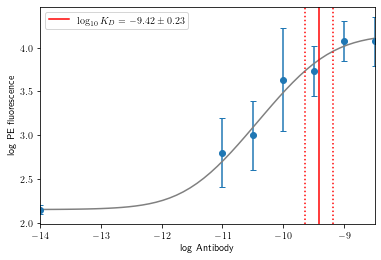

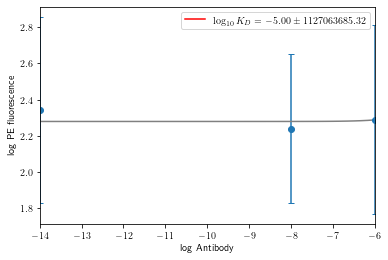

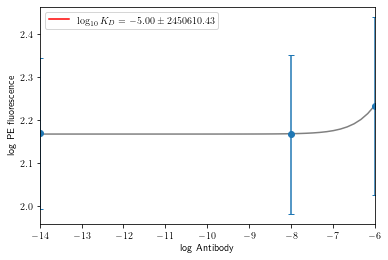

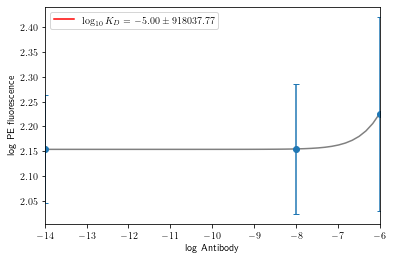

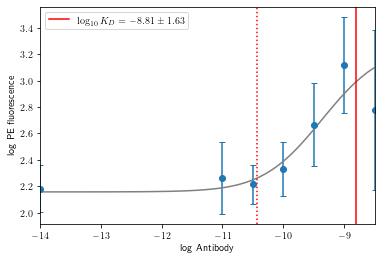

In [4]:
dfplot = pd.DataFrame()
dfplot["Strain"] =["101"]*4 + ["102"]*4
dfplot["Antibody"] = list(spl.antibody.unique())*2
dfplot["SA"] = dfplot.Strain + "_" + dfplot.Antibody
dct, dct_err = {}, {}
for sp in spl.Strain.unique():
    for ab in spl.antibody.unique():
        df = spl[(spl.Strain == sp) & (spl.antibody == ab) & (spl.log_concentration != -7)]
        popt, pcov = measure_Kds(df.mean_log_PE, df.std_log_PE, df.log_concentration)
        fig, ax = plt.subplots()
        plot_fit(df.mean_log_PE, df.std_log_PE, df.log_concentration, popt, pcov, ax)
        dct[sp+"_"+ab] = popt[0]
        dct_err[sp+"_"+ab] = pcov[0][0]
    
dfplot["Kd_isogenic"] = -dfplot.SA.map(dct)
dfplot["Kd_isogenic_err"] = dfplot.SA.map(dct_err)
    

In [5]:
dfplot

,Strain,Antibody,SA,Kd_isogenic,Kd_isogenic_err
0,101,CB6,101_CB6,5.000000,1.127064e+09
1,101,555,101_555,5.000000,2.450610e+06
2,101,REGN,101_REGN,5.000000,9.180378e+05
3,101,S309,101_S309,8.811949,1.625712e+00
4,102,CB6,102_CB6,10.499386,2.413302e-01
5,102,555,102_555,10.476311,2.511725e-01
6,102,REGN,102_REGN,10.440941,2.306963e-01
7,102,S309,102_S309,9.415104,2.260648e-01


In [6]:
directory = "../../Additional_data/Isogenic_measurement/20220305_antibodies"
sample_list = pd.read_csv(f"{directory}/samples_list.csv")


def read_file(r):
    try:
        return glob(
    f"../../Additional_data/Isogenic_measurement/20220305_antibodies/export_Specimen_???_{r['Sample']}_*_Expressing.csv")[0]
                                                                     
    except:
        print("ok")
sample_list["filename"] = sample_list.apply(lambda r: read_file(r),
                                                  axis=1)


def read_PEs(csv_file):
    df = pd.read_csv(csv_file)
    try:
        return df["Comp-PE-A"].to_list()
    except:
        return df["PE-A"].to_list()
        

def read_FITCs(csv_file):
    df = pd.read_csv(csv_file)
    try:
        return df["Comp-FITC-A"].to_list()
    except:
        return df["FITC-A"].to_list()

sample_list["PEs"] = sample_list.filename.apply(read_PEs)
sample_list["FITCs"] = sample_list.filename.apply(read_FITCs)
minFITCs = sample_list.FITCs.apply(np.min).min()
minPEs = sample_list.PEs.apply(np.min).min()
sample_list["logFITCs"] = sample_list.FITCs.apply(lambda x: [np.log10(u - minFITCs + 1) for u in x])
sample_list["logPEs"] = sample_list.PEs.apply(lambda x: [np.log10(u - minPEs + 1) for u in x])
sample_list["mean_log_PE"] = sample_list.logPEs.apply(np.mean)
sample_list["std_log_PE"] = sample_list.logPEs.apply(np.std)# / np.sqrt(df.PEs.apply(len))
spl = sample_list[(sample_list.Control == 0) & (~sample_list.is_bad)].copy()
spl["antibody"] = spl.Antibody.map({'16': 'CB6', 'REGN': 'REGN', '555': '555', 'S309': 'S309'})
spl["log_concentration"] = spl.log_concentration.apply(lambda x: -14.0 if float(x)==0 else float(x))
spl["Strain"] = spl.Strain.apply(str)

[-9.54147774e+00  4.07887374e+04  2.73205434e+02]
[-1.05466218e+01  2.44252516e+04  8.85057663e+03]
[-1.04052312e+01  3.88843917e+04  1.38916925e+03]
[-9.23917156e+00  3.13002126e+04  1.80139523e+02]
[ -9.0091964  785.49445996 271.59579076]
[  -8.8578036  1061.27364629  305.79234726]
[  -8.96358338 2545.36030387  500.20086571]
[-8.42534594e+00  2.07864683e+04  2.23378778e+02]


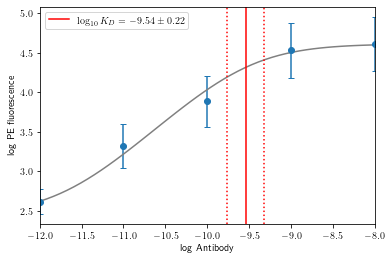

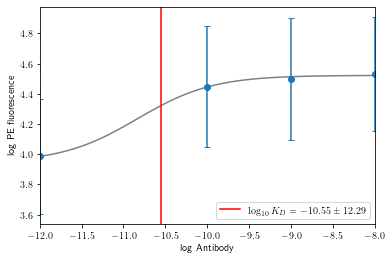

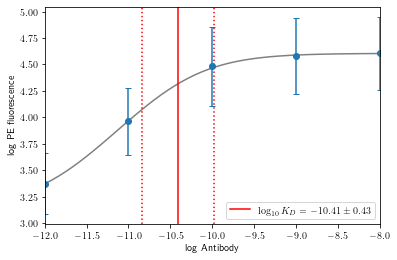

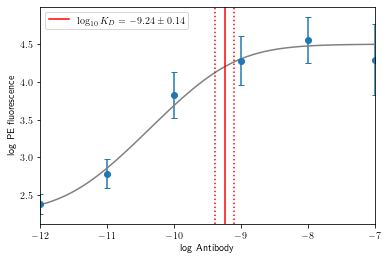

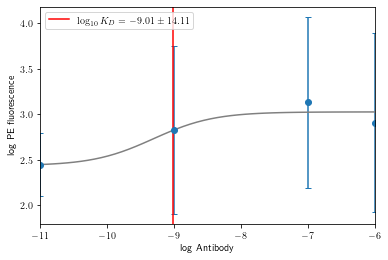

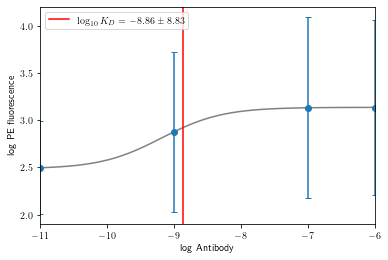

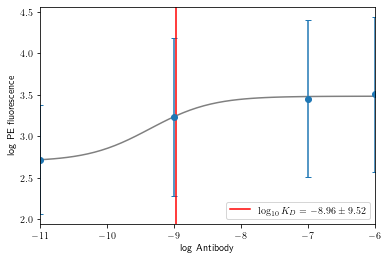

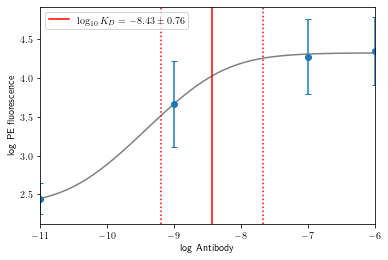

In [7]:

dct, dct_err = {}, {}
for sp in spl.Strain.unique():
    for ab in spl.antibody.unique():
        df = spl[(spl.Strain == sp) & (spl.antibody == ab)]
        popt, pcov = measure_Kds(df.mean_log_PE, df.std_log_PE, df.log_concentration)
        fig, ax = plt.subplots()
        plot_fit(df.mean_log_PE, df.std_log_PE, df.log_concentration, popt, pcov, ax)
        print(popt)
        dct[sp+"_"+ab] = popt[0]
        dct_err[sp+"_"+ab] = pcov[0][0]
    
dfplot["Kd_isogenic_rep2"] = -dfplot.SA.map(dct)
dfplot["Kd_isogenic_err_rep2"] = dfplot.SA.map(dct_err)
    

In [11]:
dct, dct_err = {}, {}
for ab in ['CB6', 'CoV555', 'REGN10987', 'S309']:
    dft = pd.read_csv(f"../../../omicron/Titeseq/results/Kds/cleaned_Kds_RBD_{ab}_proper.tsv",
                 dtype={"geno":"str"}, sep=",")
    dft.log10Kd = dft.log10Kd.apply(lambda x: 6 if pd.isna(x) else x)
    mapp = {'CB6':'CB6', 'CoV555':'555', 'REGN10987':'REGN', 'S309':'S309'}
    dct['101' +"_" + mapp[ab]] = dft[dft.geno == '1'*15].log10Kd.iloc[0]
    dct['102'+"_"+ mapp[ab]] = dft[dft.geno == '0'*15].log10Kd.iloc[0]
    dct_err['101' +"_" + mapp[ab]] = dft[dft.geno == '1'*15].err_log10Kd.iloc[0]
    dct_err['102'+"_"+ mapp[ab]] = dft[dft.geno == '0'*15].err_log10Kd.iloc[0]
dfplot["Kd_titeseq"] = -dfplot.SA.map(dct)
dfplot["Kd_err_titeseq"] = dfplot.SA.map(dct_err)
 

In [12]:
dfplot["mean_Kd_isogenic"] = np.nanmean([dfplot["Kd_isogenic"], dfplot["Kd_isogenic_rep2"]], axis=0)
dfplot["err_Kd_isogenic"] = 1/2*np.abs(dfplot["Kd_isogenic"] -dfplot["mean_Kd_isogenic"]) + 1/2*np.abs(dfplot["Kd_isogenic_rep2"] -dfplot["mean_Kd_isogenic"])

In [13]:
dfplot.to_csv("isogenic_results.csv")

In [14]:
pd.read_csv("isogenic_results.csv")

,Unnamed: 0,Strain,Antibody,SA,Kd_isogenic,Kd_isogenic_err,Kd_isogenic_rep2,Kd_isogenic_err_rep2,Kd_titeseq,Kd_err_titeseq,mean_Kd_isogenic,err_Kd_isogenic
0,0,101,CB6,101_CB6,5.000000,1.127064e+09,NaN,NaN,-6.000000,NaN,5.000000,NaN
1,1,101,555,101_555,5.000000,2.450610e+06,NaN,NaN,-6.000000,NaN,5.000000,NaN
2,2,101,REGN,101_REGN,5.000000,9.180378e+05,NaN,NaN,-6.000000,NaN,5.000000,NaN
3,3,101,S309,101_S309,8.811949,1.625712e+00,NaN,NaN,-8.586621,0.163565,8.811949,NaN
4,4,102,CB6,102_CB6,10.499386,2.413302e-01,10.546622,12.289669,-9.805361,0.021116,10.523004,0.023618
5,5,102,555,102_555,10.476311,2.511725e-01,9.541478,0.219766,-10.194024,0.244169,10.008894,0.467417
6,6,102,REGN,102_REGN,10.440941,2.306963e-01,10.405231,0.428715,-9.959268,0.048214,10.423086,0.017855
7,7,102,S309,102_S309,9.415104,2.260648e-01,9.239172,0.139507,-9.343234,0.090333,9.327138,0.087966


Text(0, 0.5, 'Titeseq')

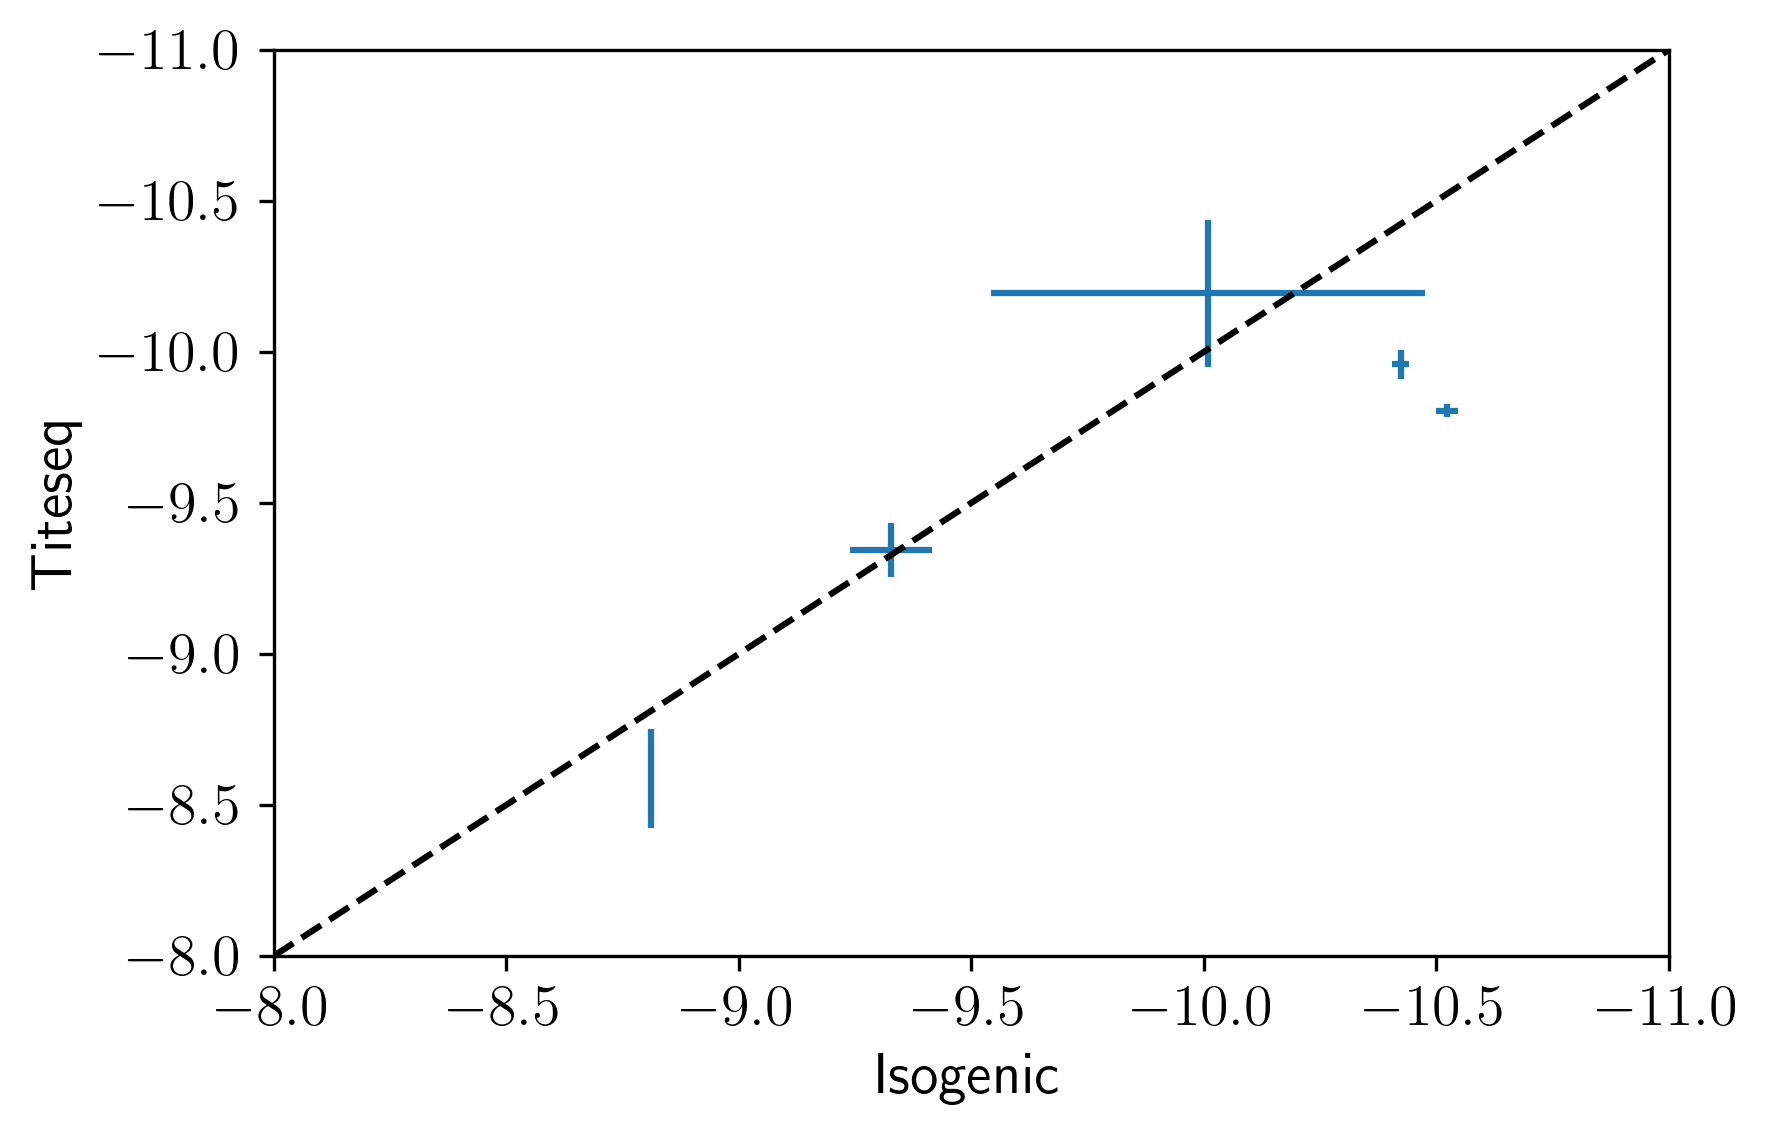

In [90]:
plt.errorbar(x=-dfplot.mean_Kd_isogenic, y=dfplot.Kd_titeseq,
            xerr=-dfplot.err_Kd_isogenic, yerr=dfplot.Kd_err_titeseq,
            ls='')
plt.plot([-8, -11], [-8, -11], ls='--', c='k')
plt.ylim(-8, -11)
plt.xlim(-8, -11)
plt.xlabel("Isogenic")
plt.ylabel("Titeseq")

In [80]:
spl[spl['Antibody'] == '555']

,Sample,log_concentration,Strain,Antibody,Control,is_bad,filename,PEs,FITCs,logFITCs,logPEs,mean_log_PE,std_log_PE,antibody
1,A3,-8.0,102,555,0,0,../../Additional_data/Isogenic_measurement/202...,"[29323.4, 52347.6, 26368.6, 58053.6, 12623.0, ...","[9822.24, 18234.0, 9413.28, 19727.3, 5024.16, ...","[3.9231133996944165, 4.2250310373365805, 3.901...","[4.470003351268651, 4.720461301894068, 4.42418...",4.617360,0.343538,555
2,A4,-9.0,102,555,0,0,../../Additional_data/Isogenic_measurement/202...,"[44218.8, 43717.0, 25410.2, 48004.6, 42288.5, ...","[28667.5, 32873.0, 23303.5, 32820.5, 30556.1, ...","[4.434931835304959, 4.497320060951083, 4.33962...","[4.647458476014529, 4.642523081745418, 4.40822...",4.534045,0.347337,555
3,A5,-10.0,102,555,0,0,../../Additional_data/Isogenic_measurement/202...,"[9503.28, 7046.64, 5147.28, 2197.44, 7827.12, ...","[32076.0, 21227.0, 15786.7, 7252.56, 15747.1, ...","[4.486164578075174, 4.296275466460342, 4.15660...","[3.9864223672896744, 3.8594721492073902, 3.727...",3.886783,0.321505,555
4,A6,-11.0,102,555,0,0,../../Additional_data/Isogenic_measurement/202...,"[2471.76, 1848.24, 2808.72, 1572.48, 2320.56, ...","[26026.6, 44505.4, 36924.5, 15480.0, 27062.6, ...","[4.390614387579677, 4.634080480350517, 4.54998...","[3.424992645092129, 3.3090251401382345, 3.4767...",3.316203,0.275321,555
5,A7,-12.0,102,555,0,0,../../Additional_data/Isogenic_measurement/202...,"[288.72, 244.8, 34.56, 300.96, 250.56, 100.08,...","[33153.8, 32539.7, 6018.48, 29116.1, 42707.5, ...","[4.501183093839962, 4.492689723146839, 3.66026...","[2.6791006896704235, 2.6372094491014253, 2.349...",2.610670,0.157058,555
24,E1,-6.0,LIB,555,0,0,../../Additional_data/Isogenic_measurement/202...,"[118.8, 18.72, 53497.4, 190.8, -15.12, -13.68,...","[35148.2, 30829.7, 21303.4, 72493.2, 1844.64, ...","[4.527674230152427, 4.468124808281811, 4.29794...","[2.48815572376571, 2.3173110202068115, 4.72986...",2.906626,0.983512,555
25,E2,-7.0,LIB,555,0,0,../../Additional_data/Isogenic_measurement/202...,"[62529.8, 28952.6, 812.88, -35.28, 12902.4, 11...","[26691.8, 25540.6, 5141.52, 55805.0, 30685.0, ...","[4.40221046811721, 4.381942070749532, 3.567821...","[4.7973971864332485, 4.464512200501793, 3.0007...",3.130317,0.940571,555
26,E4,-9.0,LIB,555,0,0,../../Additional_data/Isogenic_measurement/202...,"[6.48, 4443.84, -21.6, 64.08, -12.24, -15.84, ...","[7115.76, 10026.7, 6425.28, 6408.0, 30520.1, 3...","[3.753659647285999, 3.933585473869456, 3.69727...","[2.2909245593827543, 3.6658398021726257, 2.223...",2.822767,0.921271,555
27,E6,-11.0,LIB,555,0,0,../../Additional_data/Isogenic_measurement/202...,"[10.08, 86.4, -4.32, 52.56, 51.84, 1.44, 766.8...","[80747.3, 17492.4, 262143.0, 41678.6, 28622.2,...","[4.899287097662093, 4.205411173168421, 5.41613...","[2.298853076409707, 2.4398377608816957, 2.2662...",2.446473,0.340940,555


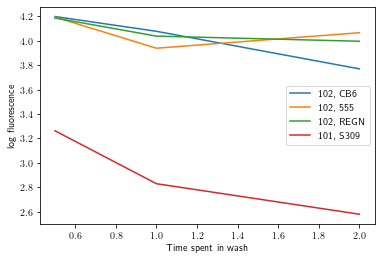

In [13]:
st = 102
ab = "555"

for st in sample_list.Strain.unique():
    for ab in sample_list.antibody.unique():
        dft = sample_list[(sample_list.antibody == ab) & (sample_list.Strain == st) & (sample_list.type == "koff")]
        if len(dft) == 0:
            continue
        dct = dft.set_index("log_concentration").mean_log_PE.to_dict()
        times = ["30min", "1hr", "2hr"]
        float_times = {"30min": 0.5, "1hr": 1, "2hr": 2}
        plt.plot([float_times[t] for t in times], [dct[t] for t in times], label=f"{st}, {ab}")
plt.legend()
plt.ylabel("log fluorescence")
plt.xlabel("Time spent in wash")
plt.show()